### 按照表格，建立真实加密货币市场事件集合


In [25]:
import pandas as pd

# === 1. 读取 TDA 结果 ===
file_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_merged_new.csv"
df = pd.read_csv(file_path)

# === 2. 转换日期格式 ===
df["date"] = pd.to_datetime(df["date"])

df = df.set_index("date")   # 很关键：用日期作为 index，方便事件窗口分析
print(df.head())
print(df.info())

# === 3. 定义事件列表 ===
events = [
    "2020-12-01","2021-01-02","2021-01-07","2021-01-29","2021-02-16",
    "2021-03-13","2021-04-10","2021-05-19","2021-05-12","2021-05-17",
    "2021-05-18","2021-06-09","2021-09-24","2021-10-15","2021-11-15",
    "2022-04-27","2022-05-01","2022-05-11","2022-05-12","2022-05-13",
    "2022-07-20","2022-11-01","2023-03-01","2023-03-10","2023-05-17",
    "2023-06-16","2023-07-01","2023-10-01","2024-03-19","2024-04-20",
    "2025-01-20","2025-02-03","2025-02-21","2025-03-07","2025-05-20",
    "2025-06-05","2025-06-17"
]
events = pd.to_datetime(events)
print(events[:5])

            time_index  vol_wass_betti0  vol_wass_betti1  vol_wass_entropy  \
date                                                                         
2020-08-21           0             1.26              0.0               0.0   
2020-08-22           1             1.24              0.0               0.0   
2020-08-23           2             1.22              0.0               0.0   
2020-08-24           3             1.26              0.0               0.0   
2020-08-25           4             1.28              0.0               0.0   

            log_wass_betti0  log_wass_betti1  log_wass_entropy  \
date                                                             
2020-08-21             1.54              0.0               0.0   
2020-08-22             1.62              0.0               0.0   
2020-08-23             1.62              0.0               0.0   
2020-08-24             1.72              0.0              -0.0   
2020-08-25             1.64              0.0             

In [26]:
import pandas as pd
import numpy as np

# === 事件窗口长度 ===
window = 30  

results = []

for e in events:
    if e not in df.index: 
        continue
    
    # 事件前窗口：e - 30天 到 e
    before = df.loc[e - pd.Timedelta(days=window) : e]["log_dtw_betti0"]
    
    # 事件后窗口：e 到 e + 30天
    after = df.loc[e : e + pd.Timedelta(days=window)]["log_dtw_betti0"]
    
    # 跳过数据不足情况
    if len(before) < 5 or len(after) < 5:
        continue
    
    results.append({
        "event": e.date(),
        "before_mean": before.mean(),
        "after_mean": after.mean(),
        "change_after_minus_before": after.mean() - before.mean(),
        "before_std": before.std(),
        "after_std": after.std(),
        "n_before": len(before),
        "n_after": len(after)
    })

res_df = pd.DataFrame(results)
print(res_df)

         event  before_mean  after_mean  change_after_minus_before  \
0   2020-12-01     1.967097    2.174194                   0.207097   
1   2021-01-02     2.221935    2.683226                   0.461290   
2   2021-01-07     2.342581    2.776129                   0.433548   
3   2021-01-29     2.643871    2.944516                   0.300645   
4   2021-02-16     2.947097    2.358710                  -0.588387   
5   2021-03-13     2.521935    2.290323                  -0.231613   
6   2021-04-10     2.241935    2.620000                   0.378065   
7   2021-05-19     2.581290    2.183226                  -0.398065   
8   2021-05-12     2.604516    2.324516                  -0.280000   
9   2021-05-17     2.588387    2.221290                  -0.367097   
10  2021-05-18     2.584516    2.201290                  -0.383226   
11  2021-06-09     2.367097    1.916129                  -0.450968   
12  2021-09-24     1.925806    1.756129                  -0.169677   
13  2021-10-15     1

In [27]:
import scipy.stats as stats
import pandas as pd

# results 是之前 append 的字典列表
res_df = pd.DataFrame(results)

# 提取 change 列
changes = res_df["change_after_minus_before"]

# 对变化量进行单样本 t 检验
t_stat, p_val = stats.ttest_1samp(changes, popmean=0)

print(f"T-statistic = {t_stat:.4f}")
print(f"P-value     = {p_val:.4e}")

T-statistic = -0.0126
P-value     = 9.9004e-01


log_dtw_betti0 在事件前后没有显示出一致方向的均值差异，但这并不说明指标无效，只说明它的事件响应方向异质，需要按事件类型细分或改用更适配的检验方法。

In [29]:
hit_rate = (changes > 0).mean()
print("Hit Rate:", hit_rate)

# 事件发生后 Betti-0 增加的比例小于0.5，Betti-0 可能是预警类信号，非“冲击后反应类信号“。

Hit Rate: 0.5945945945945946


In [30]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

window = 30

results = []

for e in events:
    if e not in df.index:
        continue
    
    # 事件前 0~30 天
    pre_window = df.loc[e - pd.Timedelta(days=window): e]['log_dtw_betti0']
    
    # 基准期（事件前 60~30 天）
    baseline_window = df.loc[e - pd.Timedelta(days=2*window): e - pd.Timedelta(days=window)]['log_dtw_betti0']
    
    # 跳过样本不足的情况
    if len(pre_window) < 10 or len(baseline_window) < 10:
        continue

    diff = pre_window.mean() - baseline_window.mean()

    # t 检验（事件前是否显著 > 基准期）
    t, p = ttest_rel(pre_window, baseline_window, alternative='greater')

    results.append({
        "event": e.date(),
        "baseline_mean": baseline_window.mean(),
        "pre_mean": pre_window.mean(),
        "difference": diff,
        "t_stat": t,
        "p_value": p
    })

res_df = pd.DataFrame(results)
print(res_df)


         event  baseline_mean  pre_mean  difference     t_stat       p_value
0   2020-12-01       1.605806  1.967097    0.361290  13.353788  1.844928e-14
1   2021-01-02       1.983871  2.221935    0.238065   4.505677  4.684558e-05
2   2021-01-07       1.998065  2.342581    0.344516   5.546135  2.493085e-06
3   2021-01-29       2.153548  2.643871    0.490323  10.344334  1.033780e-11
4   2021-02-16       2.520645  2.947097    0.426452  11.846715  3.844421e-13
5   2021-03-13       2.854194  2.521935   -0.332258  -2.784272  9.954001e-01
6   2021-04-10       2.589677  2.241935   -0.347742  -3.088858  9.978476e-01
7   2021-05-19       2.456129  2.581290    0.125161   2.073679  2.339530e-02
8   2021-05-12       2.290323  2.604516    0.314194   4.406864  6.176947e-05
9   2021-05-17       2.414194  2.588387    0.174194   2.733107  5.208887e-03
10  2021-05-18       2.433548  2.584516    0.150968   2.443127  1.033086e-02
11  2021-06-09       2.620000  2.367097   -0.252903  -7.526502  1.000000e+00

In [31]:
hit_rate = (res_df['p_value'] < 0.05).mean()
hit_rate

np.float64(0.5135135135135135)

### 整体的AUC&ROC对比

In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import timedelta


df['event_label'] = False
window = 30  # 事件窗口

# 生成事件标签
for e in events:
    df.loc[e - timedelta(days=window) : e + timedelta(days=window), 'event_label'] = True

df['event_label'] = df['event_label'].astype(int)
indicators = [
    "vol_wass_betti0", "vol_wass_betti1", "vol_wass_entropy",
    "log_wass_betti0", "log_wass_betti1", "log_wass_entropy",
    "log_dtw_betti0",  "log_dtw_betti1",  "log_dtw_entropy",
    "vol_dtw_betti0",  "vol_dtw_betti1",  "vol_dtw_entropy"
]

results = []

y_true = df['event_label']

for ind in indicators:
    y_score = df[ind]
    
    # 忽略NaN
    mask = ~y_score.isna()
    y_true_masked = y_true[mask]
    y_score_masked = y_score[mask]
    
    fpr, tpr, _ = roc_curve(y_true_masked, y_score_masked)
    roc_auc = auc(fpr, tpr)
    results.append((ind, roc_auc))

# 按AUC降序排列
results = sorted(results, key=lambda x: x[1], reverse=True)

for ind, auc_value in results:
    print(f"{ind}: AUC = {auc_value:.3f}")

log_dtw_betti0: AUC = 0.618
vol_dtw_betti0: AUC = 0.613
log_wass_betti0: AUC = 0.612
vol_wass_betti0: AUC = 0.607
log_dtw_entropy: AUC = 0.512
log_wass_betti1: AUC = 0.508
vol_wass_betti1: AUC = 0.504
vol_dtw_betti1: AUC = 0.503
vol_wass_entropy: AUC = 0.500
log_dtw_betti1: AUC = 0.500
log_wass_entropy: AUC = 0.499
vol_dtw_entropy: AUC = 0.498


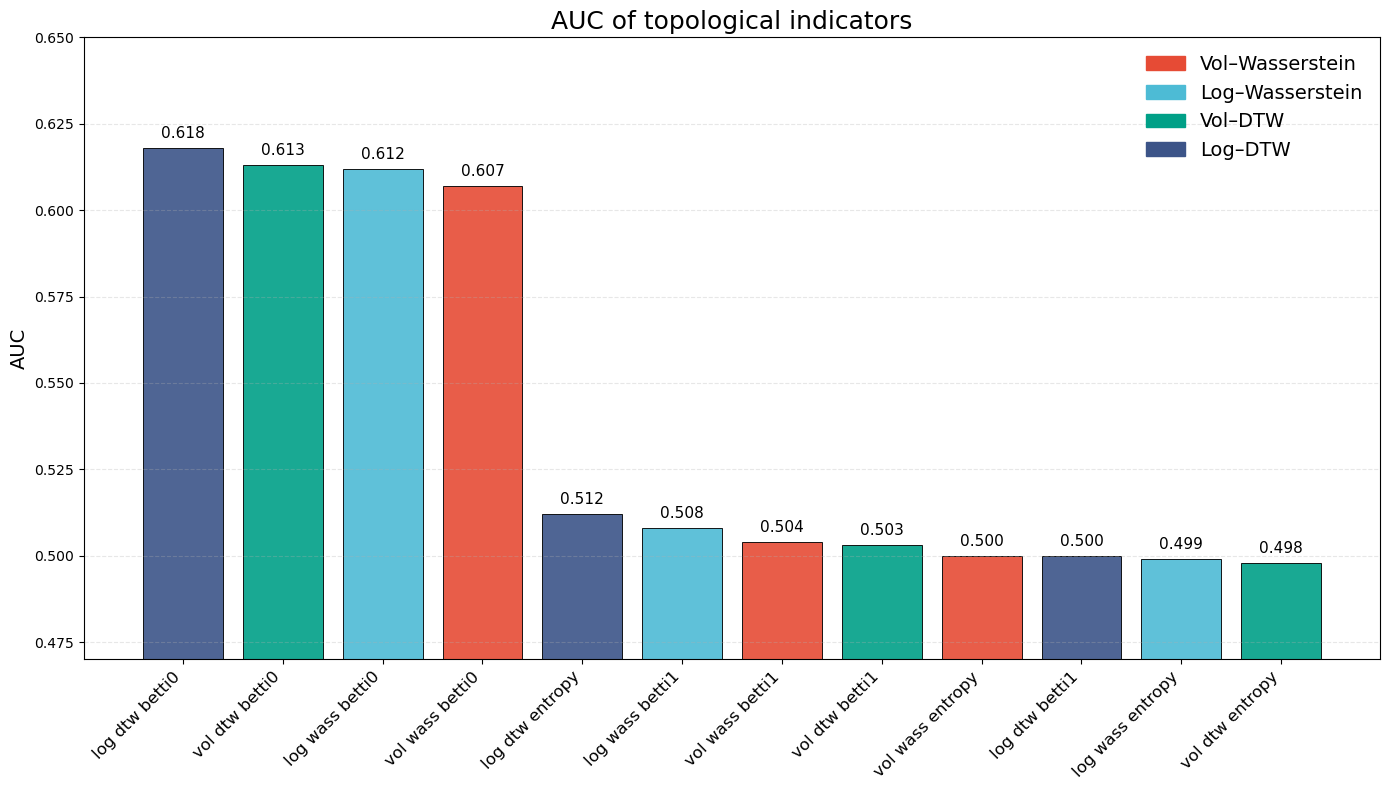

Saved to: /Users/jane/Documents/202511吾-Systems/4.Plot/Fig2/auc_comparison_tda_vertical.png


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# ======== 1. 最新 AUC 数据 ========
auc_dict = {
    "log_dtw_betti0": 0.618,
    "vol_dtw_betti0": 0.613,
    "log_wass_betti0": 0.612,
    "vol_wass_betti0": 0.607,
    "log_dtw_entropy": 0.512,
    "log_wass_betti1": 0.508,
    "vol_wass_betti1": 0.504,
    "vol_dtw_betti1": 0.503,
    "vol_wass_entropy": 0.500,
    "log_dtw_betti1": 0.500,
    "log_wass_entropy": 0.499,
    "vol_dtw_entropy": 0.498,
}

# ======== 2. 标签（保持原样）========
label_map = {name: name.replace("_", " ") for name in auc_dict}

# ======== 3. 四类方法颜色 ========
color_map = {
    "vol_wass": "#E64B35FF",   # 橙红
    "log_wass": "#4DBBD5FF",   # 蓝绿
    "vol_dtw":  "#00A087FF",   # 祖母绿
    "log_dtw":  "#3C5488FF",   # 深蓝
}

def get_color(name):
    if "vol_wass" in name:
        return color_map["vol_wass"]
    if "log_wass" in name:
        return color_map["log_wass"]
    if "vol_dtw" in name:
        return color_map["vol_dtw"]
    if "log_dtw" in name:
        return color_map["log_dtw"]
    return "#999999"

# ======== 4. 排序（高→低）========
sorted_items = sorted(auc_dict.items(), key=lambda x: x[1], reverse=True)
names    = [i[0] for i in sorted_items]
auc_vals = [i[1] for i in sorted_items]
colors   = [get_color(n) for n in names]
labels   = [label_map[n] for n in names]

# ======== 5. 画图（竖直）========
fig, ax = plt.subplots(figsize=(14, 8))  # 16:9 稍微长一点

x_pos = np.arange(len(names))

bars = ax.bar(
    x_pos, auc_vals,
    color=colors,
    edgecolor="black",
    linewidth=0.7,
    alpha=0.9
)

# x 轴标签
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=12, rotation=45, ha="right")

# y 轴范围（完全展示0~1）
ax.set_ylim(0.47, 0.65)

# 在柱顶添加 AUC 数字
for bar, v in zip(bars, auc_vals):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.002,
        f"{v:.3f}",
        ha="center", va="bottom", fontsize=11
    )

# 轴/标题
ax.set_ylabel("AUC", fontsize=14)
ax.set_title("AUC of topological indicators", fontsize=18)

# 网格
ax.yaxis.grid(True, linestyle="--", alpha=0.3)

# 图例
legend_handles = [
    Patch(color=color_map["vol_wass"], label="Vol–Wasserstein"),
    Patch(color=color_map["log_wass"], label="Log–Wasserstein"),
    Patch(color=color_map["vol_dtw"],  label="Vol–DTW"),
    Patch(color=color_map["log_dtw"],  label="Log–DTW"),
]
ax.legend(handles=legend_handles, fontsize=14, frameon=False, loc="upper right")

plt.tight_layout()

# 保存
save_path = "/Users/jane/Documents/202511吾-Systems/4.Plot/Fig2/auc_comparison_tda_vertical.png"
fig.savefig(save_path, dpi=900, bbox_inches="tight")

plt.show()
print("Saved to:", save_path)

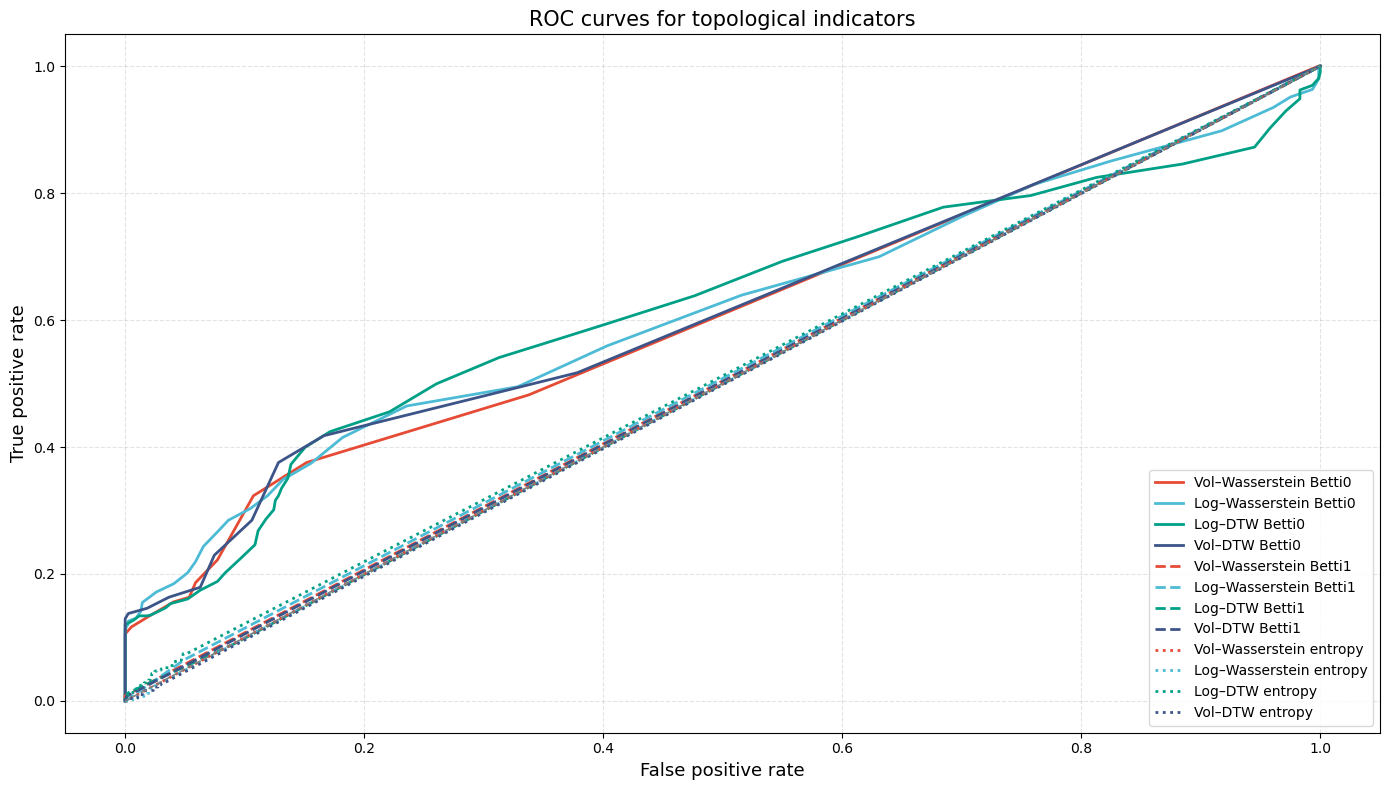

⭐ ROC 图已保存： /Users/jane/Documents/202511吾-Systems/4.Plot/Fig2/fig_roc_tda_clean.png


In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

# ======================
# 1. 指标 + 颜色 + 线型
# ======================

indicators = [
    ("vol_wass_betti0",  "Vol–Wasserstein Betti0"),
    ("log_wass_betti0",  "Log–Wasserstein Betti0"),
    ("log_dtw_betti0",   "Log–DTW Betti0"),
    ("vol_dtw_betti0",   "Vol–DTW Betti0"),

    ("vol_wass_betti1",  "Vol–Wasserstein Betti1"),
    ("log_wass_betti1",  "Log–Wasserstein Betti1"),
    ("log_dtw_betti1",   "Log–DTW Betti1"),
    ("vol_dtw_betti1",   "Vol–DTW Betti1"),

    ("vol_wass_entropy", "Vol–Wasserstein entropy"),
    ("log_wass_entropy", "Log–Wasserstein entropy"),
    ("log_dtw_entropy",  "Log–DTW entropy"),
    ("vol_dtw_entropy",  "Vol–DTW entropy"),
]

# 颜色（与先前图对应）
color_map = {
    "vol_wass": "#E64B35",   # 红橙
    "log_wass": "#4DBBD5",   # 蓝绿
    "log_dtw":  "#00A087",   # 绿色
    "vol_dtw":  "#3C5488",   # 深蓝
}

# 线型（按特征类型区分）
ls_map = {
    "betti0":  "-",     # 实线
    "betti1":  "--",    # 虚线
    "entropy": ":"      # 点线
}

# ======================
# 2. 绘制 ROC 曲线
# ======================

plt.figure(figsize=(14, 8))   # 16:9 比例

y_true = df["event_label"].values

for col, label in indicators:

    # 颜色组
    if "vol_wass" in col:
        color = color_map["vol_wass"]
    elif "log_wass" in col:
        color = color_map["log_wass"]
    elif "log_dtw" in col:
        color = color_map["log_dtw"]
    elif "vol_dtw" in col:
        color = color_map["vol_dtw"]
    else:
        color = "#999999"

    # 线型
    if "betti0" in col:
        ls = ls_map["betti0"]
    elif "betti1" in col:
        ls = ls_map["betti1"]
    else:
        ls = ls_map["entropy"]

    # 数据
    y_score = df[col].values
    mask = np.isfinite(y_score)

    fpr, tpr, _ = roc_curve(y_true[mask], y_score[mask])

    plt.plot(fpr, tpr, label=label, color=color, linestyle=ls, linewidth=2)

# 随机基线
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1.2)

# ======================
# 3. 美化
# ======================

plt.xlabel("False positive rate", fontsize=13)
plt.ylabel("True positive rate", fontsize=13)
plt.title("ROC curves for topological indicators", fontsize=15)

plt.grid(True, linestyle="--", alpha=0.35)

# 图例：放在图内部右下角
plt.legend(
    loc="lower right",
    fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.85,
    edgecolor="lightgray"
)

plt.tight_layout()

# ======================
# 4. 保存 900 DPI
# ======================
save_path = "/Users/jane/Documents/202511吾-Systems/4.Plot/Fig2/fig_roc_tda_clean.png"
plt.savefig(save_path, dpi=900, bbox_inches="tight")
plt.show()

print("⭐ ROC 图已保存：", save_path)

Results: 当AUC >0.55，属于弱但显著高于随机（系统性风险早期信号常见区间）。
在金融系统性风险研究中，AUC 0.55–0.65 就具有经济意义,尤其是市场危机早期结构信号。